## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [4]:
#read in ab_data.csv and store in df, taking a look at the first few rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
#find number of rows in dataset
df.shape
#294478 rows

(294478, 5)

In [6]:
#The number of unique users in the dataset
df.user_id.nunique()

290584

In [7]:
#proportion of users converted
df.converted.mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [8]:
#number of times treatment group member does not receive the new page
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

Do any of the rows have missing values?

In [9]:
#no nulls/missing values in any rows
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. We need to drop the rows where a treatment group member does not receive the new page and assign new dataframe for df2.

In [12]:
#drop all rows where treatment and new_page don't line up and assign that new dataframe to df2
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)

In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [15]:
#unique user ids in df2
df2.user_id.nunique()

290584

In [16]:
#User Id that appears twice in df2
nonunique = df2.user_id.value_counts()
nonunique[nonunique > 1].index[0]

773192

In [17]:
#row info for the repeat user id
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [18]:
#drop one of the duplicate user id rows
df2 = df2.drop(df2.index[2893])

In [19]:
#probability of an individual converting regardless of page they receive
df2.converted.mean()

0.11959708724499628

In [20]:
#probability of individual converting given they are in the control group
c_ctrl = df2.query('group == "control"')['converted'].mean()
c_ctrl

0.1203863045004612

In [21]:
#probability of an individual converting given that they are in the treatment group
c_trt = df2.query('group == "treatment"')['converted'].mean()
c_trt

0.11880806551510564

In [33]:
#observed difference in conversion rates between control and treatment group
obs_diff = c_trt-c_ctrl
obs_diff

-0.0015782389853555567

In [34]:
#probability that an individual received the new page
df2.query('landing_page == "new_page"').shape[0]/df2['landing_page'].shape[0]

0.5000619442226688

**No evidence so far that one page leads to more conversions.**
> Across the board, conversion rate is 12%, whether we're looking at aggregate conversion rates, only amongst those in treatment or control group. There is no evidence thus far that one page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, we're going to try and make a decision just based on all the data provided.  We want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.  **$p_{old}$** and **$p_{new}$** are the converted rates for the old and new pages.

> **$H_{O}$**: **$p_{new}$** - **$p_{old}$** <= 0

> **$H_{A}$**: **$p_{new}$** - **$p_{old}$** > 0

`2.` We'll assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

We'll use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

We'll perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the following cells below to complete the necessary parts of this simulation. <br><br>

a.  **convert rate** for $p_{new}$ under the null

In [35]:
#convert rate for p_new is the same as convert rate for dataset regardless of ab group
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. **convert rate** for $p_{old}$ under the null

In [36]:
#convert rate for p_old is the same as convert rate for dataset regardless of ab group
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. $n_{new}$

In [37]:
#sample size for the new page aka the treatment group, is the same as the size of the treatment group
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. $n_{old}$

In [38]:
#sample size for the old page aka the control group, is the same as the size of the control group
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [39]:
new_page_converted = np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [40]:
old_page_converted = np.random.binomial(1, p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [41]:
# difference in average conversions for above simulations between control and treatment group
(new_page_converted.mean()) - (old_page_converted.mean())

0.00010799059139121603

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process.  Store all 10,000 values in **p_diffs**.

In [42]:
#simulate 10,000 new page conversions of trial size n_new
new_page_conversions = np.random.binomial(n_new,p_new,10000)

#simulate 10,000 old page conversions of trial size n_old
old_page_conversions = np.random.binomial(n_old,p_old,10000)

#calculate the difference in proportion of conversions between all the simulations above
p_diffs = [(x/n_new) - (y/n_old) for x, y in zip(new_page_conversions, old_page_conversions)]

i. Plot a histogram of the **p_diffs** and a red line marking where obs_diff is

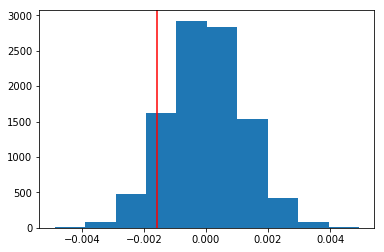

In [43]:
plt.hist(p_diffs)
plt.axvline(obs_diff, c='r');

j. Proportion of **p_diffs** greater than the actual difference observed in **ab_data.csv**

In [44]:
'''add up the number of times a value in p_diffs was greater than obs_diff from Part 1
    and divide that by total number of values in p_diffs'''
p_obs_diff = 0
for i in p_diffs:
    if i > obs_diff:
        p_obs_diff += 1
        
(p_obs_diff/len(p_diffs))

0.9005

**Results.**

> Here we calculated differences between new page conversion rates and old page conversion rates in our simulations, and then found how the proportion of those differences that are greater than the difference we calculated in our actual data. Based upon how we set up our hypothesis test, this calculation turned out to be a p-value in scientific studies, and it determines whether or not the difference between new and old pages is statistically significant. This is the probability of seeing a difference in conversions as extreme or more extreme than our actual observations, under our null hypothesis.

> With our p-value over .05, we do no have statistically significant evidence to reject the null that conversion rate differences between the old page and new page are less than or equal to 0.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [45]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1').shape[0]
convert_new = df2.query('group == "treatment" and converted == 1').shape[0]
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

/Users/christinacaddel/anaconda3/envs/sampling_distrib/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now we use `stats.proportions_ztest` to compute your test statistic and p-value. 

In [46]:
#compute test statistic and p-value for two-sided hypothesis test in which
#conversion rate difference is not equal to observed difference
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
z_score, p_value

(1.3109241984234394, 0.18988337448195103)

In [47]:
#compute test statistic and p-value for one-sided hypothesis test in which
#conversion rate difference is greater than observed difference
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'larger')
z_score, p_value

(1.3109241984234394, 0.094941687240975514)

**Statistical Significance**

> According to the z-scores and p-values computed above, we do no have statistically significant evidence to reject the null for either hypothesis test. One difference here, is that in parts j. and k. we are calculating the p-value for a one-sided hypothesis where we are only looking for p_new - p_old > 0. Here we conducted a two-sided hypothesis test where the null hypothesis is that p_new - p_old = 0 and the alternative is that p_new - p_old is not equal to 0. We did also run a one-sided hypothesis test under the same null and alternative as part j. and k. and we did find the same results, a non-statistically significant p-value of .095.

> With that, as well as looking over the context of the test, I can also say that there is not practical significance to these results. Thus far, I hold to my argument that implementing the new web page would not result in a consistent improvement in conversion rates.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we'll achieve the results from the previous A/B test by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, we will be performing logistic regression in this case.

b. The goal is to use **statsmodels** to fit the regression model we specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Let's add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [48]:
#create intercept column and dummy column for ab_page
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['landing_page'])['new_page']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [49]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [50]:
logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [51]:
#summary of model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 12 Dec 2017   Pseudo R-squ.:               8.077e-06
Time:                        19:42:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. Our p-value associated with **ab_page** here is .19 

Here is the major factor we are considering in terms of our hypotheses and how they are affecting our p-values:

> The two-sided hypothesis test that the regression model above ran, and the first values computed in **Part II m.** is stated as follows, and this is what led to our p-value of .19 in those results:

    >**$H_{O}$**: **$p_{new}$** - **$p_{old}$** = 0
    
    >**$H_{A}$**: **$p_{new}$** - **$p_{old}$** ≠ 0

> Now, the _one-sided_ hypothesis test that **Part II j.** and the second values computed in **Part II m.** is stated in the very first step of **Part II**. And this is what led to our p-value of .095 in those results. As you can see, the two-sided hypothesis test's p-value is the one-sided hypothesis test's p-value multiplied by two to complement the difference in the hypotheses.

**Considering other things that might influence conversions**

> Considering other factors to add into the regression model can open up possibilities of associations with the outcome. Disadvantages to adding additional terms into the regression model are the possibility of collinearity amongst the variables and potentially drawing a misguided conclusion if you base it just on p-values.

g. Now along with testing if the conversion rate changes for different pages, we'll also add an effect based on which country a user lives.

Does it appear that country had an impact on conversion? 

In [52]:
#reading in countries.csv, assigning to countries_df and printing head
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [53]:
#checking if there are any nulls in countries_df
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [54]:
#checking if both data frames have the same amount of unique user ids and rows before joining to avoid nulls
df2.user_id.nunique(), countries_df.user_id.nunique()

(290583, 290584)

In [55]:
#make sure user ids in each dataframe match up
df2['user_id'].index.name == countries_df['user_id'].index.name

True

In [56]:
#join countries_df to df2 on the 'user_id' column
df2 = df2.join(countries_df.set_index('user_id'),on='user_id')

In [57]:
#get value count for each country to get idea of size
df2.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [58]:
#create dummy variables for the 'country' column and join to df2
countries = pd.get_dummies(df2['country'])
df2 = df2.join(countries)

In [59]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [60]:
#instantiate, fit and run summary of new regression model with 'ab_page', 'UK', 'US', and Canada as the baseline
logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page','UK','US']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Dec 2017   Pseudo R-squ.:               2.323e-05
Time:                        19:45:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [61]:
#calculate magnitude at which baseline variable has effect over other categorical variables
1/np.exp(.0506), 1/np.exp(.0408)

(0.95065885803307093, 0.96002111497165088)

In [62]:
#calculate magnitude at which variables have effect over response variable
np.exp(results.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

Based on the p-values and running this regression model under a two-sided hypothesis, it looks like we still don't have any statistical significance on our variables to say that they would have an influence on conversions. If we did have statistical significance, in order to interpret the results of the country variables here, we have to do so in terms of our baseline country variable, Canada. 
<br><br> If an individual lives in Canada, they are between .95 and .96 times more likely to convert than if they lived in the UK or US, holding all other variables constant.
<br><br> If an individual is in the treatment group, they are .98 times more likely to convert, holding all other variables constant.

h. I'm now going to look at an interaction between page and country to see if there are significant effects on conversion.  We'll create the necessary additional columns, fit the new model, provide summary results, and conclusions based on the results. 

In [63]:
#create new columns: 1 = both in that country and in treatment group, 0 = in that country and in control group
df2['US_ab'] = np.multiply(df2['ab_page'],df2['US'])
df2['UK_ab'] = np.multiply(df2['ab_page'],df2['UK'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,US_ab,UK_ab
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [64]:
logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page','US','UK','US_ab','UK_ab']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 12 Dec 2017   Pseudo R-squ.:               3.482e-05
Time:                        19:47:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US_ab          0.0469      0.054      0.872      0.383      -0.059       0.152
UK_ab          0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

In [65]:
1/np.exp(.0783), 1/np.exp(.0469), 1/np.exp(.0118), 1/np.exp(.0175), np.exp(results.params)

(0.92468697883481332,
 0.95418281110072634,
 0.98826934696725455,
 0.98265223566507331,
 intercept    0.134794
 ab_page      0.934776
 US           1.017682
 UK           1.011854
 US_ab        1.048001
 UK_ab        1.081428
 dtype: float64)

Again, we have no variables that provide statistically significant evidence of having an influence on conversions. However, for the sake of explanation in the event that they did, let's interpret the influence of the variables.
<br><br> If an individual lives in Canada _and_ is in the treatment group, they are .93 and .95 times more likely to convert than if they lived in the US or the UK and were in the treatment group, respectively.

Now, let's look at the duration of the A/B Test and given our results in these previous logistic regression models, make a recommendation to the company about how to proceed.

In [66]:
from datetime import date, datetime

# duration of this experiment
max_date = datetime.strptime(str(max(df['timestamp'])[0:10]), '%Y-%m-%d')
min_date = datetime.strptime(str(min(df['timestamp'])[0:10]), '%Y-%m-%d')
max_date - min_date

datetime.timedelta(22)

The duration of this A/B Test is 22 days long. I would recommend letting the test run for a few weeks longer in order to account for the change averse existing customers who may have been turned off by this new page feature and give them some time to get used to it. If we get similar results after a few weeks, I would recommend refraining from proceeding with implementation of this new web page.